In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input/Multi-Class Prediction of Obesity Risk'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

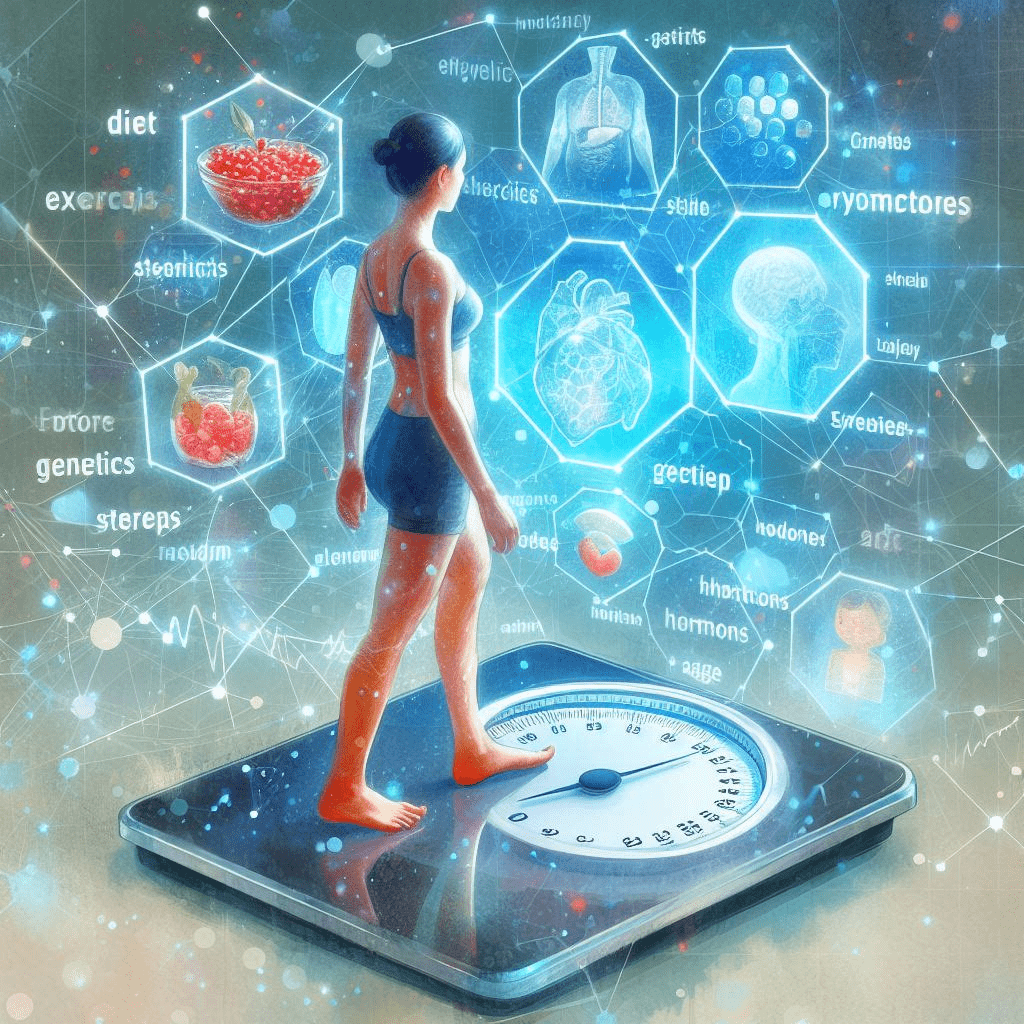

# Let's load and explore datasets

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')

In [3]:
#lowercase the col names for convineance
train.columns = [s.lower() for s in train.columns.tolist()]
train.rename(columns={'family_history_with_overweight':'family_history'}, inplace=True)

test.columns = [s.lower() for s in test.columns.tolist()]
test.rename(columns={'family_history_with_overweight':'family_history'}, inplace=True)

In [4]:
train.head()

,id,gender,age,height,weight,family_history,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,nobeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


# categorical features

In [5]:
train.select_dtypes(include='object').columns

Index(['gender', 'family_history', 'favc', 'caec', 'smoke', 'scc', 'calc',
       'mtrans', 'nobeyesdad'],
      dtype='object')

In [6]:
train.gender.value_counts()

gender
Female    10422
Male      10336
Name: count, dtype: int64

In [7]:
train.age.value_counts().sort_values(ascending=False)

age
18.000000    1916
26.000000    1806
21.000000    1643
23.000000    1202
19.000000     886
             ... 
21.356288       1
25.191627       1
19.005725       1
38.939448       1
33.852953       1
Name: count, Length: 1703, dtype: int64

In [8]:
train.nobeyesdad.value_counts()

nobeyesdad
Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: count, dtype: int64

In [9]:
#there are 2 columns say index, fix it 
train.set_index('id', inplace= True)
test.set_index('id', inplace= True)

Let's see the number of unique values in each of the columns

In [10]:
train_unique_values = {}  #feature:nunique()
test_unique_values = {}

for data in [train, test]:
    for col in data.columns:
        if data[col].dtypes == 'object':
            if 'nobeyesdad' in data.columns.tolist():
                train_unique_values[col] = data[col].nunique()
                
            else: test_unique_values[col] = data[col].nunique()
                

train_unique_values['DataFrame'] = 'train_'
test_unique_values['DataFrame'] = 'test_'

combo = pd.DataFrame([train_unique_values, test_unique_values])
combo

,gender,family_history,favc,caec,smoke,scc,calc,mtrans,nobeyesdad,DataFrame
0,2,2,2,4,2,2,3,5,7.0,train_
1,2,2,2,4,2,2,4,5,NaN,test_


# observation 
in all the features except the calc, the number of unique value matches. THis mismatch can be problematic as there might be a new class in the testset which is important but we are missing out, so lets see the value counts of this difference. Lets see which rows are having these `always` classes

In [11]:
train.calc.value_counts()

calc
Sometimes     15066
no             5163
Frequently      529
Name: count, dtype: int64

In [12]:
test.calc.describe()

count         13840
unique            4
top       Sometimes
freq           9979
Name: calc, dtype: object

In [13]:
test.loc[test['calc'] == 'Always']

,gender,age,height,weight,family_history,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans
id,,,,,,,,,,,,,,,,
24781,Female,20.0,1.66,60.0,yes,yes,3.0,3.0,Always,no,2.0,no,0.0,0.0,Always,Public_Transportation
28201,Male,21.0,1.67,66.5,no,yes,2.0,3.0,Frequently,no,2.0,no,1.0,0.0,Always,Public_Transportation


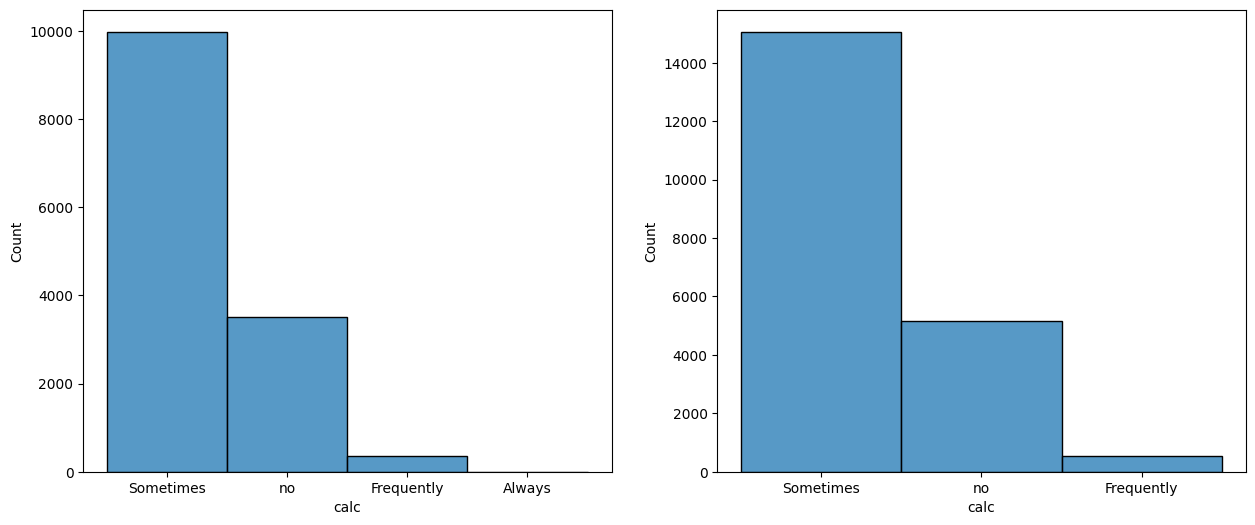

In [14]:
plot, axes = plt.subplots(1,2, figsize=(15,6))
sns.histplot(data=test, x='calc', ax=axes[0])
sns.histplot(data=train, x='calc', ax=axes[1])

plt.show()

# takeout
as we see, the difference is bc in the test class we have a new category of `always` not there are different ways to handle such difference. 
- Ignore the category
- Merge the category with a similar close one: (BE AWARE of the risk of  bias or misrepresentation into your analysis)
- create a new category for the trainset as well 

In this notebook i decided to add `train['calc_Always'] = 0` becuase later that we do onehotencoding it will be in the columns list. Additionally, also merging is not a good approach since other features are somewhat different with other instances so i decided to not risk and just ignore it for now. Finally if you choose to go for the third approach then you might add `train['calc_always'] = 0` this way you show that you actually realized it!

Lets now see the classes within each feature.

In [15]:
train['calc_Always'] = 0

In [16]:
cat_features = train.select_dtypes(include=['object']).columns.tolist()

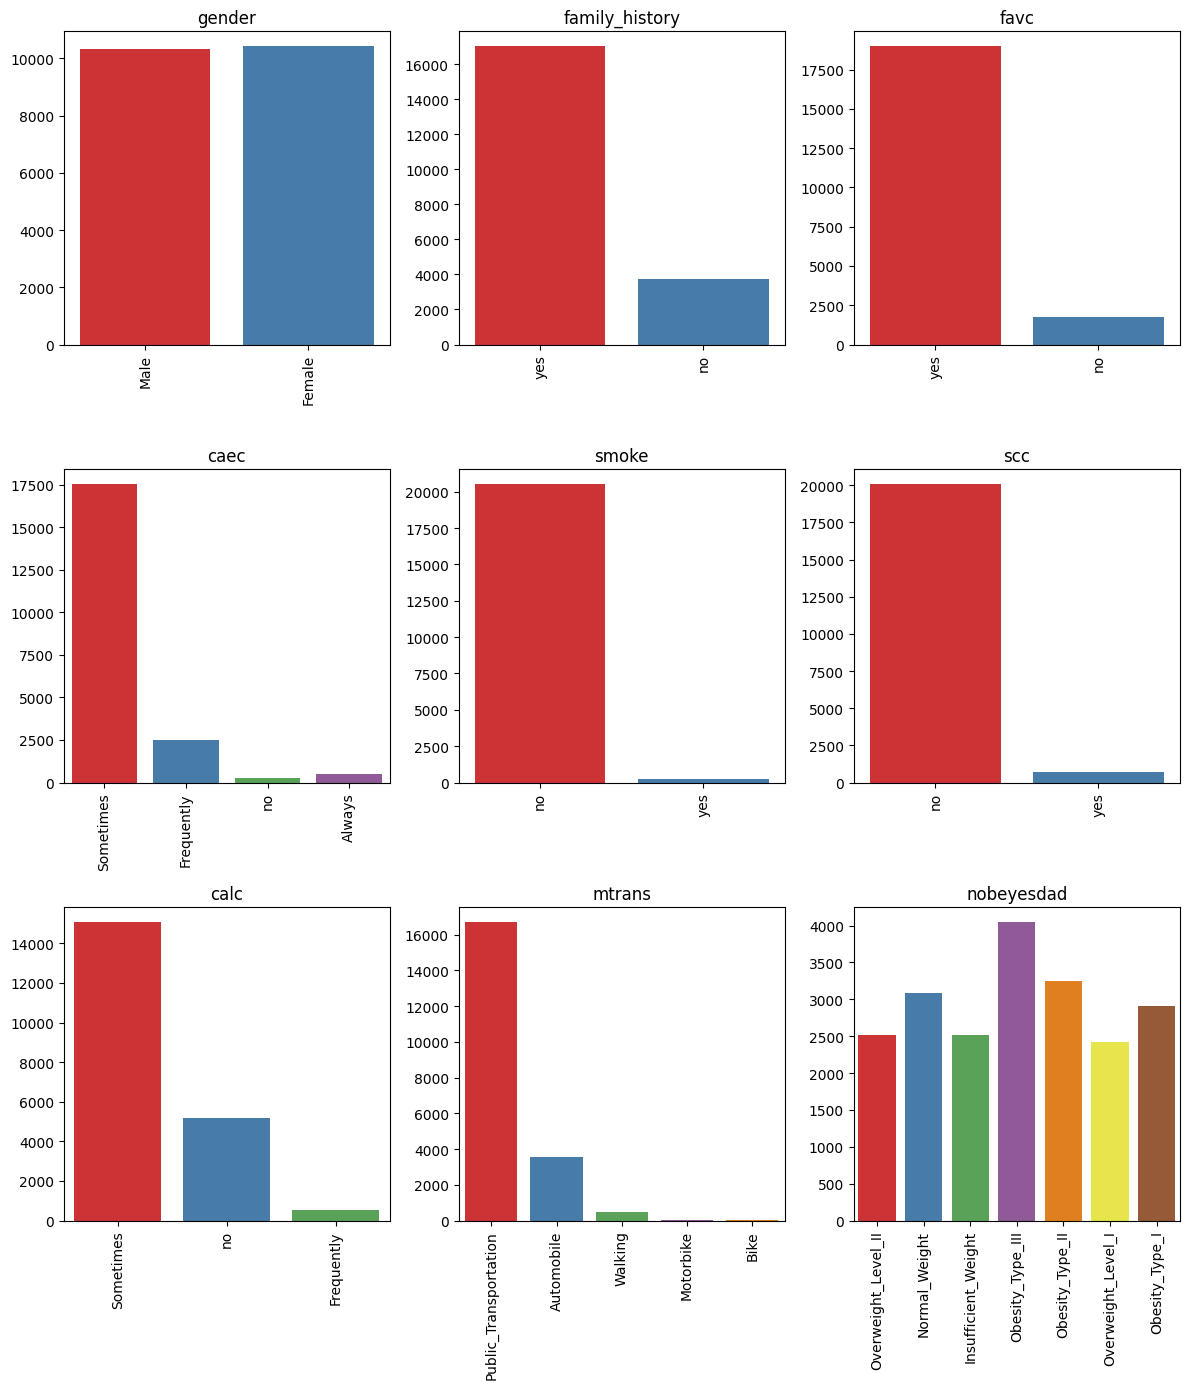

In [17]:
plot, axes = plt.subplots(3,3, figsize=(12,14))
axes = axes.flatten()

colors = []
for i, feature in enumerate(cat_features):
    sns.countplot(data=train, x=feature, ax=axes[i], palette='Set1')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_title(feature)
    axes[i].set_xticklabels(labels=axes[i].get_xticklabels(), rotation=90)
        
plt.tight_layout()

# observation 
we are seeing a huge difference in the class balance of each of the features. For instance in the `smoke` majority of the samples are non-smoking, same for `scc`. So lets see the impact on the obesity class...

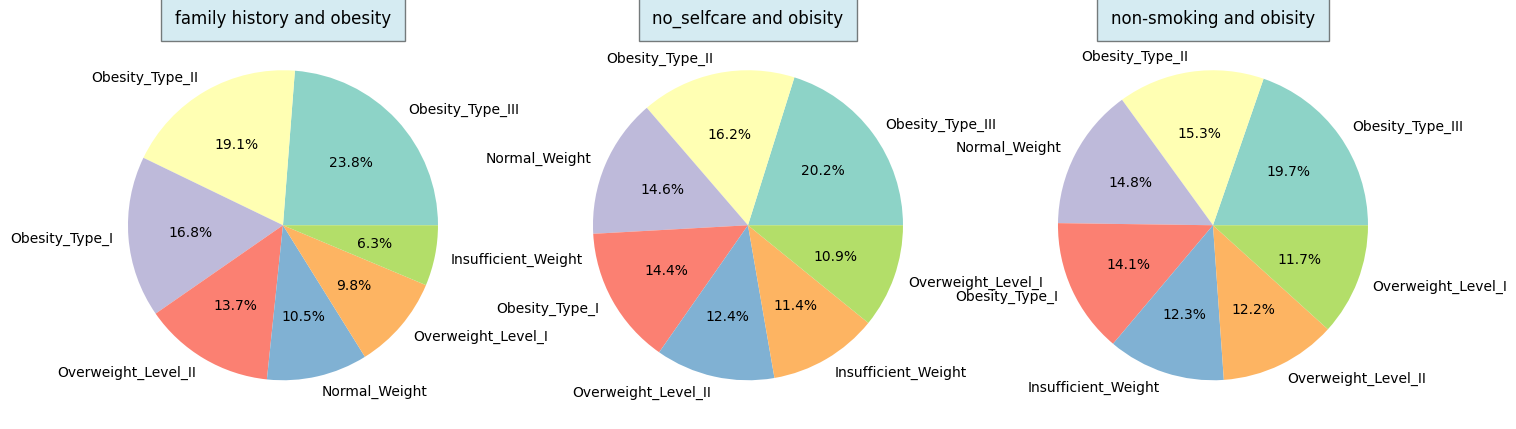

In [18]:
non_smoking = train[train.smoke == 'no'].nobeyesdad.value_counts()
no_selfcare = train[train.scc == 'no'].nobeyesdad.value_counts()
has_fam_history = train[train.family_history == 'yes'].nobeyesdad.value_counts()

list_features = [has_fam_history, no_selfcare, non_smoking]
titles = ['family history and obesity', 'no_selfcare and obisity', 'non-smoking and obisity']

fig, ax = plt.subplots(1, 3, figsize=(17,15))

for i, feature in enumerate(list_features):
    ax[i].pie(x=feature, labels=feature.index, autopct='%.1f%%', colors=sns.color_palette('Set3'))
    ax[i].set_title(titles[i % len(titles)], bbox={'facecolor': 'lightblue', 'alpha': 0.5, 'pad': 10})
    #ax[i].set_xticklabels(labels=ax[i].get_xticklabels(), rotation=45)
    ax[i].set_xticklabels(labels=ax[i].get_xticklabels(), rotation=45)


plt.show()


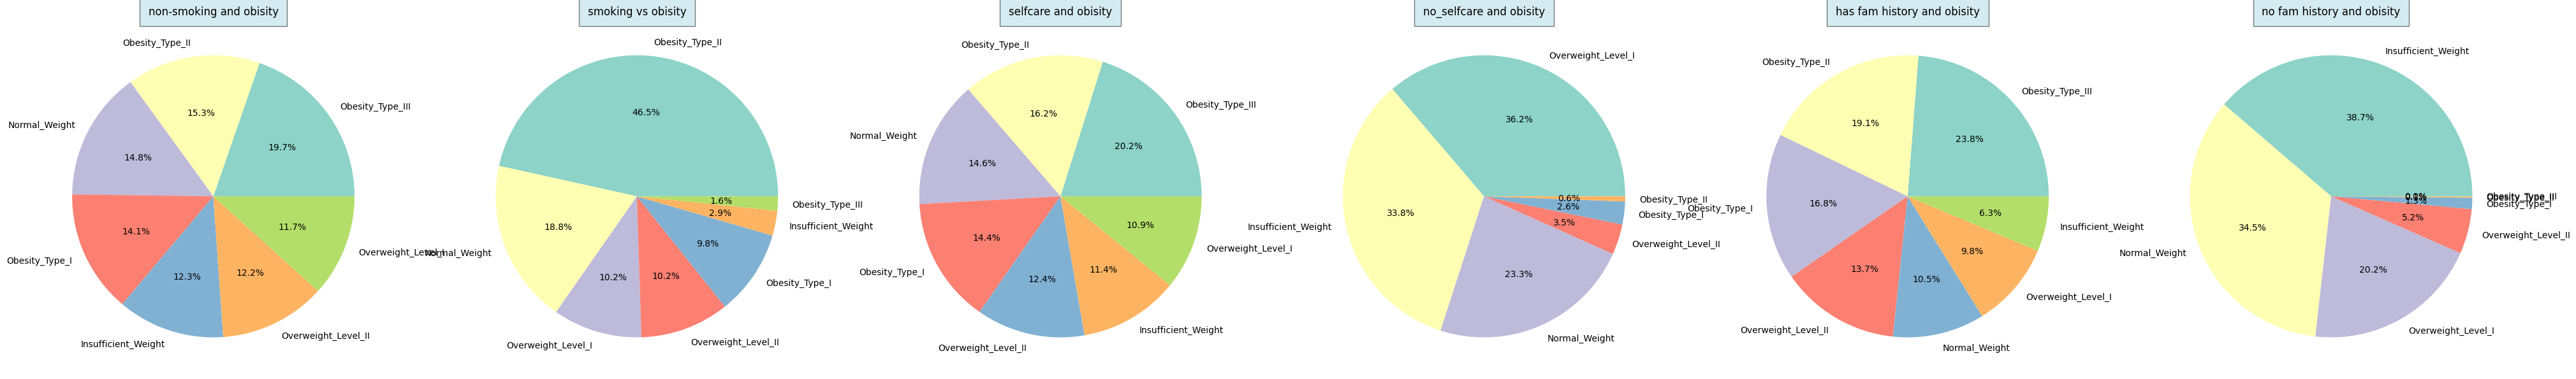

In [19]:
#non smoking vs smoking and the distribution in the obisity
non_smoking = train[train.smoke == 'no'].nobeyesdad.value_counts()
smoking = train[train.smoke == 'yes'].nobeyesdad.value_counts()

#no selfcare vs selfcare and the distribution in obisity
no_selfcare = train[train.scc == 'no'].nobeyesdad.value_counts()
selfcare = train[train.scc == 'yes'].nobeyesdad.value_counts()

#no fam hisory vs famhistory 
has_fam_history = train[train.family_history == 'yes'].nobeyesdad.value_counts()
no_fam_history = train[train.family_history == 'no'].nobeyesdad.value_counts()

list_features = [non_smoking, smoking, no_selfcare, selfcare, has_fam_history, no_fam_history]
titles = ['non-smoking and obisity', 'smoking vs obisity', 'selfcare and obisity','no_selfcare and obisity', 'has fam history and obisity', 'no fam history and obisity']

fig, ax = plt.subplots(1,6, figsize=(50,15))

for i, feature in enumerate(list_features):
    ax[i].pie(x=feature, labels=feature.index, autopct='%.1f%%', colors=sns.color_palette('Set3'))
    ax[i].set_title(titles[i % len(titles)], bbox={'facecolor': 'lightblue', 'alpha': 0.5, 'pad': 10})
    ax[i].set_xticklabels(labels=ax[i].get_xticklabels(), rotation=45)

plt.show()


now lets see the obeyesed itself to see whether we have a balanced class or not 

In [20]:
class_ob = train['nobeyesdad'].value_counts()
class_ob

nobeyesdad
Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: count, dtype: int64

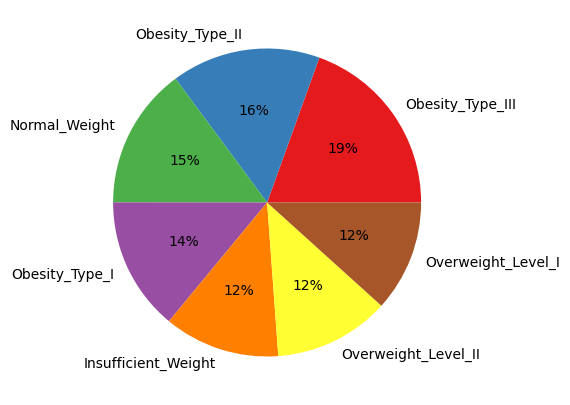

In [21]:
plot, ax = plt.subplots(figsize=(5,5))
ax.pie(x= class_ob,autopct='%.0f%%', labels=class_ob.index, colors=sns.color_palette('Set1'))
plt.show()

as we can see we have a fairly balanced class for each of the labels

# Numeric features Distributions
Alright, now lets see the distribution of the numeric features to see we have any skewed distribution or outliers or so

## Numeric features

In [22]:
numeric_train = train.select_dtypes(include=['float64'])

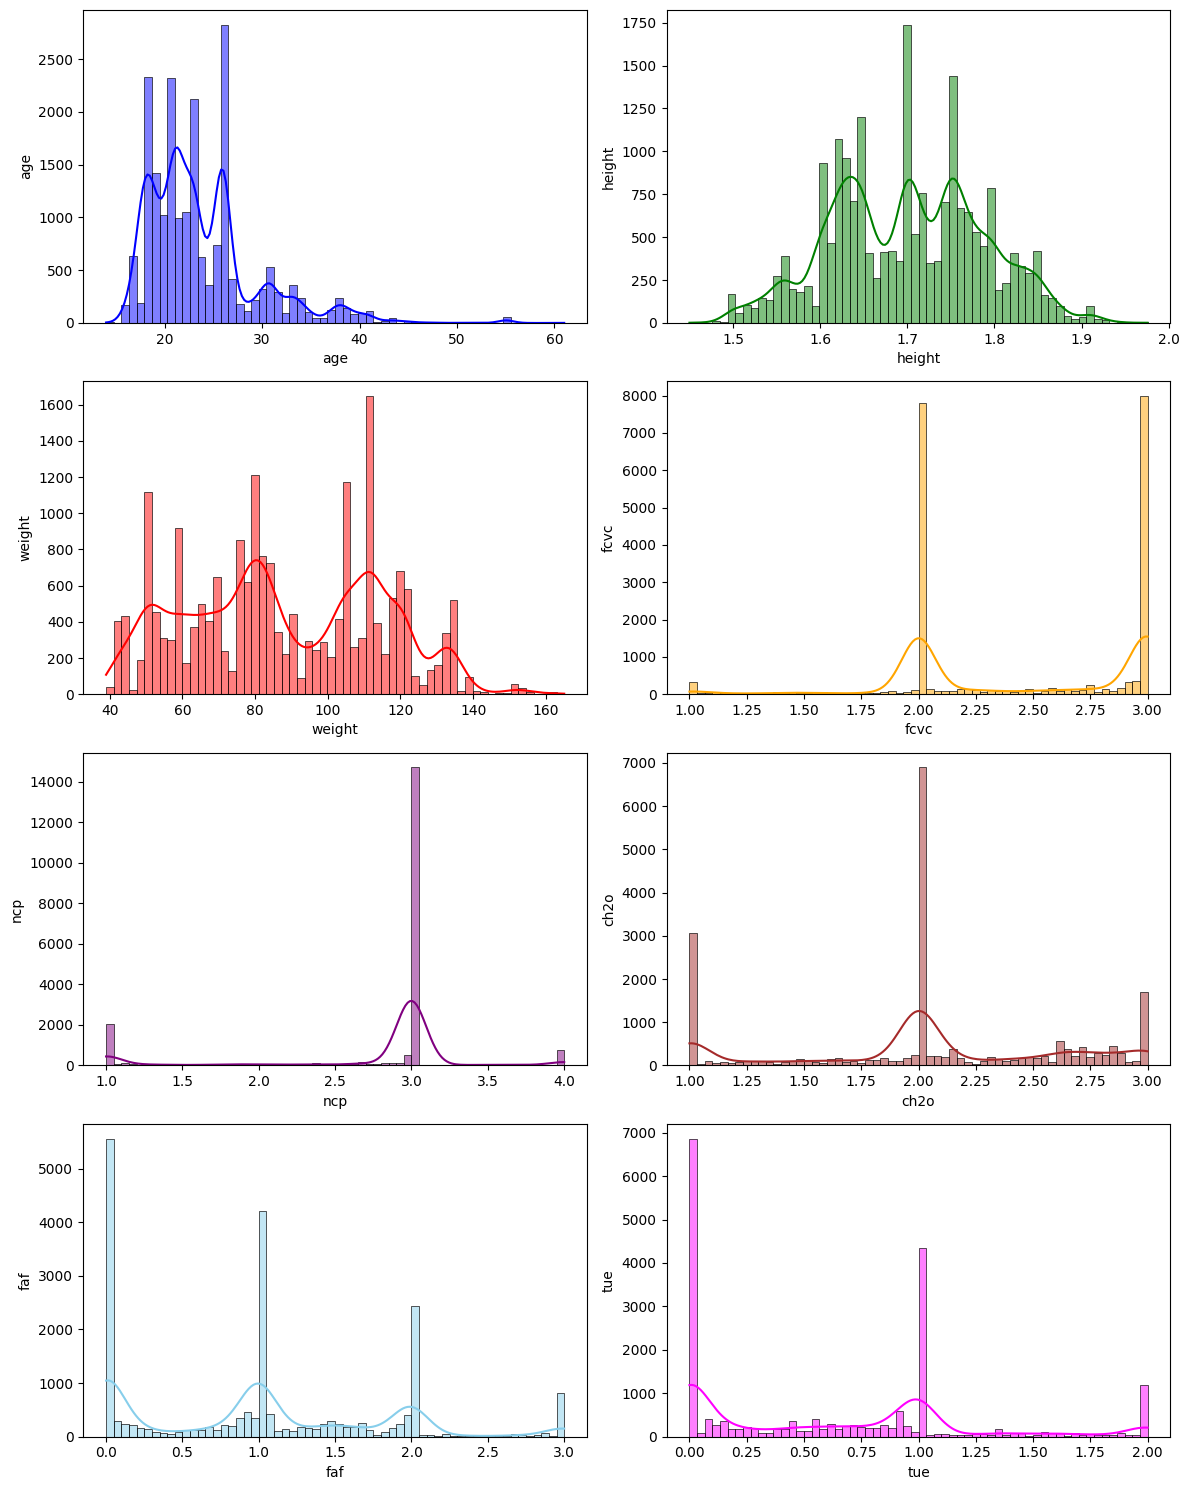

In [23]:
plot, axs = plt.subplots(4,2, figsize=(12,15))
axs = axs.flatten()
#plt.style.use('seaborn-v0_8-whitegrid')
colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'skyblue', 'magenta']

for i, feature in enumerate(numeric_train):
    sns.histplot(data=train, x=feature , ax= axs[i], bins=60, kde=True, color=colors[i % len(colors)])
    axs[i].set_ylabel(feature)
    
    
plt.tight_layout()
plt.show()    

# observation
In `age` we can see that the distribution is skewed to right. 
This means the majority of the data is toward the left side. If we see `age.describe` we se that the mean is 23, so this kinda prove what we witness in the figure and majority of data being on left side rather than big ages! However, the overal impact of skewness is on the mean/std of the distribution. So to see whether this skewness is causing the mean to be shifted or the original data having more data toward the left side, we can see the value_counts of age. 

In [24]:
train.age.describe()

count    20758.000000
mean        23.841804
std          5.688072
min         14.000000
25%         20.000000
50%         22.815416
75%         26.000000
max         61.000000
Name: age, dtype: float64

In [25]:
train.age.value_counts().sort_values(ascending=False)

age
18.000000    1916
26.000000    1806
21.000000    1643
23.000000    1202
19.000000     886
             ... 
21.356288       1
25.191627       1
19.005725       1
38.939448       1
33.852953       1
Name: count, Length: 1703, dtype: int64

so as seen the we have LOTS of data below the mean rather than upper mean so this is kinda in line with our prior observation. All these observations are leading to the decision that do we wanna take care of the skewness by some transformatiion techniques or so, OR no and we wanna leave it the way it is! Thats why we kinda explore age a lil bit! We will count the amount of this skewness later in the `feature engineering` section.

# calculating skewness

In [26]:
train.age.skew() 

1.5862517094133515

In [27]:
train.age.mean()

23.841804418681953

so again, i decided to not do the transformation for the skewness bc of the risk of interfering in the data or imposing some sort of bias

# adding bmi

In [28]:
## creating bmi
train['bmi'] = train.weight / (train.height) **2

In [29]:
train.head()

,gender,age,height,weight,family_history,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,nobeyesdad,calc_Always,bmi
id,,,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,0,28.259565
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,0,23.422091
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,0,17.126706
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,0,44.855798
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,0,25.599151


#  now the fun begins..

as you know, for us to be able input the data to our model, they should be in form of numbers. SO lets convert the categorical data into relevant numeric datatype but before doing so make shure to put some time fully understand why we are doing sucha thing, and what is the difference between different ways of conversion, i.e. labelencoder vs. onehotencoder vs. other ways...


# Feature Eng

In [30]:
from sklearn.preprocessing import LabelEncoder

In [31]:
#create an object
le = LabelEncoder()

In [32]:
cat_fz = train.select_dtypes(include=['object']).columns.tolist()
print(cat_fz)

if 'nobeyesdad' in cat_fz:
    cat_fz.remove('nobeyesdad')
    
for feature in train[cat_fz]:
    if train[feature].nunique() ==2 : #before it was 3 but problematic in calc -- difference test/train
        train[feature] = le.fit_transform(train[feature])    
    else:
        train[feature] = train[feature].astype('object')
    

['gender', 'family_history', 'favc', 'caec', 'smoke', 'scc', 'calc', 'mtrans', 'nobeyesdad']


In [33]:
print(cat_fz) #'nobeyesdad' should not be in it!!!

['gender', 'family_history', 'favc', 'caec', 'smoke', 'scc', 'calc', 'mtrans']


In [34]:
#convert 'nobeyesdad' seperately
le_ = LabelEncoder()
train['nobeyesdad'] = le_.fit_transform(train['nobeyesdad'])

# Separate features (X) and target variable (y)
X = train.drop('nobeyesdad', axis=1)
y = train['nobeyesdad']

In [35]:
train.nobeyesdad.value_counts()

nobeyesdad
4    4046
3    3248
1    3082
2    2910
0    2523
6    2522
5    2427
Name: count, dtype: int64

# takeout 
So here i decided to labelencode the features that are having less than 3 instances, meaning the classes that are yes/no or calc that has 3 type values bc if your categorical heature has more than say 2 or 3 types (like the transportation column) if u try to encode it with labelencoder it kinda lose its meaning. bc label encoder treat it as some sort of ranking while in our original data there is no difference interms of ranking between walking vs bike in transportation. So I decided for the **categorical_features** that are having more than 3 types, to use either OneHotEncoder from SKlearn or `pd.get_dummies` from pandas.

In [36]:
train.head()

,gender,age,height,weight,family_history,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,nobeyesdad,calc_Always,bmi
id,,,,,,,,,,,,,,,,,,,
0,1,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,Sometimes,0,2.763573,0,0.000000,0.976473,Sometimes,Public_Transportation,6,0,28.259565
1,0,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,Frequently,0,2.000000,0,1.000000,1.000000,no,Automobile,1,0,23.422091
2,0,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,Sometimes,0,1.910378,0,0.866045,1.673584,no,Public_Transportation,0,0,17.126706
3,0,20.952737,1.710730,131.274851,1,1,3.000000,3.000000,Sometimes,0,1.674061,0,1.467863,0.780199,Sometimes,Public_Transportation,4,0,44.855798
4,1,31.641081,1.914186,93.798055,1,1,2.679664,1.971472,Sometimes,0,1.979848,0,1.967973,0.931721,Sometimes,Public_Transportation,6,0,25.599151


In [37]:
train.select_dtypes(include='object').count()

caec      20758
calc      20758
mtrans    20758
dtype: int64

In [38]:
train.dtypes

gender              int64
age               float64
height            float64
weight            float64
family_history      int64
favc                int64
fcvc              float64
ncp               float64
caec               object
smoke               int64
ch2o              float64
scc                 int64
faf               float64
tue               float64
calc               object
mtrans             object
nobeyesdad          int64
calc_Always         int64
bmi               float64
dtype: object

before moving forward lets now that we have numeric features in almost most part of our trainset, lets standardilize it first, meaning run the sdandardscalar on it. the purpose is to make each of the features unit-free or unit-independent 

In [39]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
numerinc_fetures = train.select_dtypes(include=['float64' , 'int64']).columns.tolist()
if 'nobeyesdad' in numerinc_fetures:
    numerinc_fetures.remove('nobeyesdad') #remove 'nobeyesdad' bc if we do the sc on this
                                        #its gonna convert it to numeric values other than 
                                        #0,1,2,3,4,5,6 which later would be invalid for our 
                                      # xgboost model!
for feature in numerinc_fetures:
    train[feature] = sc.fit_transform(train[[feature]])

In [40]:
train.head()

,gender,age,height,weight,family_history,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,nobeyesdad,calc_Always,bmi
id,,,,,,,,,,,,,,,,,,,
0,1.004152,0.105699,-0.002828,-0.235713,0.469099,0.30588,-0.836279,0.314684,Sometimes,-0.109287,1.206594,-0.185009,-1.171141,0.597438,Sometimes,Public_Transportation,6,0.0,-0.237862
1,-0.995866,-1.027052,-1.606291,-1.170931,0.469099,0.30588,-0.836279,0.338364,Frequently,-0.109287,-0.048349,-0.185009,0.021775,0.636513,no,Automobile,1,0.0,-0.818331
2,-0.995866,-1.027052,0.128451,-1.430012,0.469099,0.30588,-1.060332,-1.913423,Sometimes,-0.109287,-0.195644,-0.185009,-0.138022,1.755239,no,Public_Transportation,0,0.0,-1.573741
3,-0.995866,-0.507929,0.120090,1.644770,0.469099,0.30588,1.039171,0.338364,Sometimes,-0.109287,-0.584035,-0.185009,0.579896,0.271455,Sometimes,Public_Transportation,4,0.0,1.753591
4,1.004152,1.371197,2.450367,0.224054,0.469099,0.30588,0.438397,-1.119801,Sometimes,-0.109287,-0.081469,-0.185009,1.176486,0.523111,Sometimes,Public_Transportation,6,0.0,-0.557096


now lets encode the remaining cat_features which are caec, mtrans. for this there are 2 approaches that are giving us kinda same result; 1. OneHotEncoder 2. `get_dummies` both will give us the onehotencoded of the words inside those features. make sure to put a bit of time to understand the way these 2 approaches are slightly different. 

Lets first drop the `nopbeyeded` columns as we dont wanna do this feature engineering on it.

In [41]:
target_col = train.pop('nobeyesdad') #difference pop, remove is that pop will save the column 

In [42]:
remained_cat_features = train.select_dtypes(include=['object']).columns.tolist()

In [43]:
print(remained_cat_features) #'nobeyesdad' should not be here

['caec', 'calc', 'mtrans']


so now we are ready to get the OneHotEncoding for the remaining categorical features, as explained above, i am using get_dummies from pandas here to get the encodings but one can also use the OneHotEncoder from sklearn, the difference is if you choose to go for sklearn approach, be careful as the fit_transfom will take 2D array as input so u either reshape it or slice the df directly!

In [44]:
# lets get the OneHot Encoding for these remaining categorical features 
train = pd.get_dummies(data=train, columns=remained_cat_features, drop_first=False, dtype='int')

In [45]:
train.head()

,gender,age,height,weight,family_history,favc,fcvc,ncp,smoke,ch2o,...,caec_Sometimes,caec_no,calc_Frequently,calc_Sometimes,calc_no,mtrans_Automobile,mtrans_Bike,mtrans_Motorbike,mtrans_Public_Transportation,mtrans_Walking
id,,,,,,,,,,,,,,,,,,,,,
0,1.004152,0.105699,-0.002828,-0.235713,0.469099,0.30588,-0.836279,0.314684,-0.109287,1.206594,...,1,0,0,1,0,0,0,0,1,0
1,-0.995866,-1.027052,-1.606291,-1.170931,0.469099,0.30588,-0.836279,0.338364,-0.109287,-0.048349,...,0,0,0,0,1,1,0,0,0,0
2,-0.995866,-1.027052,0.128451,-1.430012,0.469099,0.30588,-1.060332,-1.913423,-0.109287,-0.195644,...,1,0,0,0,1,0,0,0,1,0
3,-0.995866,-0.507929,0.120090,1.644770,0.469099,0.30588,1.039171,0.338364,-0.109287,-0.584035,...,1,0,0,1,0,0,0,0,1,0
4,1.004152,1.371197,2.450367,0.224054,0.469099,0.30588,0.438397,-1.119801,-0.109287,-0.081469,...,1,0,0,1,0,0,0,0,1,0


so we processed the prep steps succcessfuly, now we will go for modeling....

## Split the data 

In [46]:
from sklearn.model_selection import train_test_split as tts

X_train, X_test, y_train, y_test = tts(train, target_col, test_size=0.2, random_state=0)

# Modeling
now we get to the modeling phase, before getting started with the process, make sure to put a few minutes to first think about the model and why you wanna use such model!
So here is my explanation, since the problem is multi-class classifcation so we need to for the models that are a good fit for such problem 
For instance, these are the list of models you can use for such problem;
- Multinominal LogisticRegression
- Random Forest
- Gradient Boosting (e.g. XGBoost)
- SVM 
- KNN

In this tutorial i am using XGBoost for the modeling purpose. XGBoost is technically an ensemble based model, meaning we have a combo of 2 or more weak learner model that we combine all together for our predictive purpose. The way it works is actually we pick a base predictive model whose prediction can be fairly naive, we run it on our dataset, then we calculate the loss. Then based on the calculated loss, we will add a new model to be adding to the ensemble cycle, we will determine the model parapeters in a way that by adding it, the loss will potentially decrease **Note that the "gradient" in "gradient boosting" refers to the fact that we'll use gradient descent on the loss function to determine the parameters in this new model**

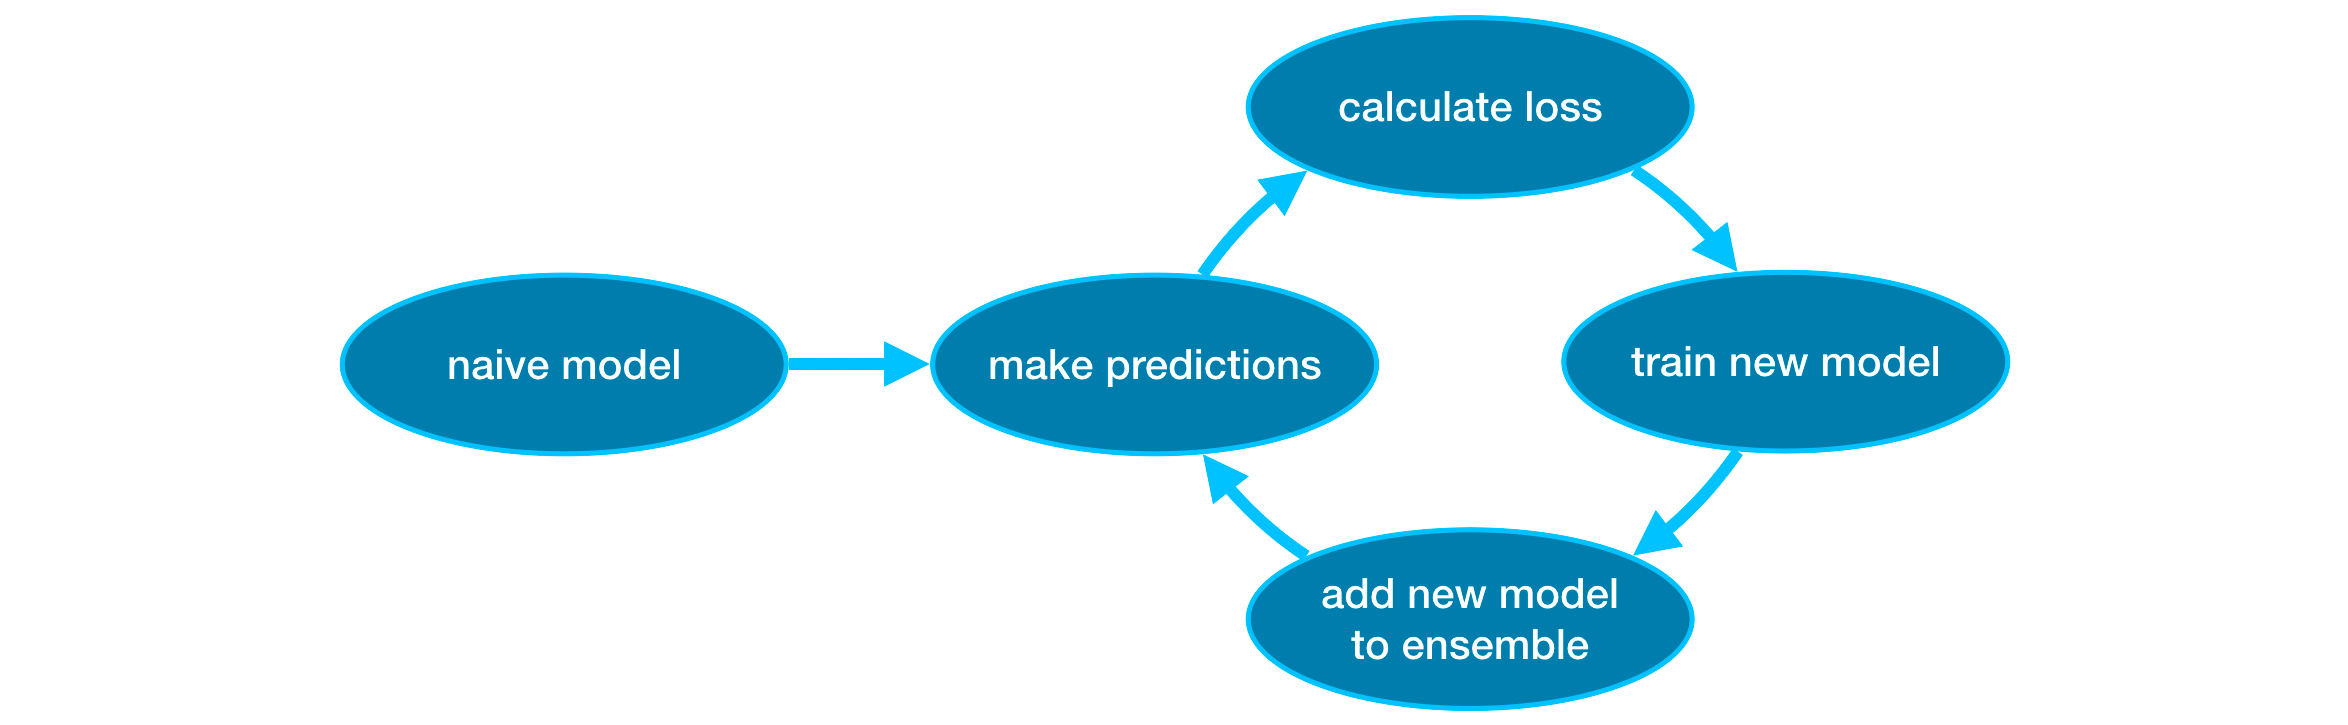

SO now that the purpose of this competition is classification so we pick the `XGClassifier`

In [47]:
from xgboost import XGBClassifier

In [48]:
params_ = {
    'booster': 'gbtree', #uses tree-based model 
    'objective': 'multi:softmax',
    'num_class': 7, #the obisity type classes
    'eval_metric': 'merror', #Multiclass classification error rate. It is calculated as #(wrong cases)/#(all cases)
    'n_estimators': 235,
    'min_split_loss': 0.08599260691424013,
    'learning_rate': 0.0567248810160126,
    'max_depth': 9,
    'subsample': 0.9863907947703492,
    'colsample_bytree': 0.3378626948499556,
    'min_child_weight': 10,
    'reg_lambda': 0.010169755101075147, #L2 regularization term on weights. Increasing this value will make model more conservative.
    'reg_alpha': 2.1888900002466063e-08,
    'validate_parameters': True,
}

In [49]:
xgb = XGBClassifier(**params_)

In [50]:
#fit the model to the train data
xgb.fit(X_train, y_train) #fit the model on the trainset

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3378626948499556, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='merror', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0567248810160126,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=10, min_split_loss=0.08599260691424013,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=235, n_jobs=None, num_class=7, ...)

In [51]:
#predict on raw testset (no preprocess is done on test set yet)
y_pred_test = xgb.predict(X_test) #predict on raw testst

In [52]:
acc = np.mean(y_pred_test == y_test) #lets examine the accuracy of our prediction

In [53]:
acc #not too bad tho...

0.9067919075144508

## Feature Importance in Gradient Boosting
A benefit of using gradient boosting is that after the boosted trees are constructed, it is relatively straightforward to retrieve importance scores for each attribute.

Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function.

The feature importances are then averaged across all of the the decision trees within the model.
[source](https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/)

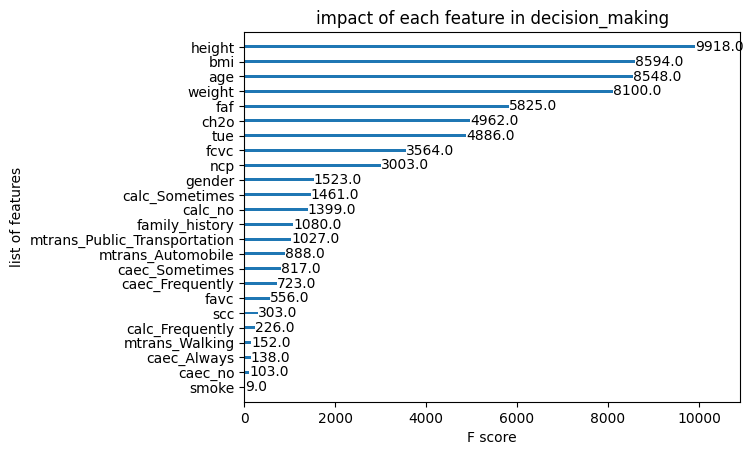

In [54]:
#plot feature importance
from xgboost import plot_importance
plot_importance(xgb, title="impact of each feature in decision_making",
                importance_type='weight', ylabel='list of features', 
                grid= False)
plt.show()

## preprocess on test set
now lets do the same preprocess steps we did for trainset, on testset;
- label encoding of cat features
- Onehot encoding of some of the cat features
- adding bmi

In [55]:
test.head()

,gender,age,height,weight,family_history,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans
id,,,,,,,,,,,,,,,,
20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


In [56]:
test.dtypes

gender             object
age               float64
height            float64
weight            float64
family_history     object
favc               object
fcvc              float64
ncp               float64
caec               object
smoke              object
ch2o              float64
scc                object
faf               float64
tue               float64
calc               object
mtrans             object
dtype: object

In [57]:
#label encoding
cat_features = [feature for feature in test.select_dtypes(include='object').columns]

for col in cat_features:
    if test[col].nunique() <= 3:
        test[col] = le.fit_transform( test[col])
    else:
        test[col] = test[col].astype('object')
        
test.dtypes

gender              int64
age               float64
height            float64
weight            float64
family_history      int64
favc                int64
fcvc              float64
ncp               float64
caec               object
smoke               int64
ch2o              float64
scc                 int64
faf               float64
tue               float64
calc               object
mtrans             object
dtype: object

In [58]:
# adding bmi
test['bmi'] = test.weight / (test.height) **2

In [59]:
#standardlizing 
numeric_features = test.select_dtypes(include=['int64','float64']).columns.tolist()
for feature in numeric_features:
    test[feature] = sc.fit_transform(test[[feature]])

In [60]:
cat = test.select_dtypes(include=['object']).columns.tolist()
#onhotencoding remaining cat features
test = pd.get_dummies(data=test, columns=cat, drop_first=False, dtype='int')

In [61]:
#fix the column order 
train_order = train.columns.tolist()
test = test[train_order]

In [62]:
y_pred_submission = xgb.predict(test)

In [63]:
y_pred_submission_df = pd.DataFrame(y_pred_submission)

In [64]:
y_pred_submission_df = y_pred_submission_df.set_index(test.index.to_series())

In [65]:
y_pred_submission_df = y_pred_submission_df.set_axis(labels=['NObeyesdad'], axis=1)

In [66]:
y_pred_submission

array([3, 5, 4, ..., 0, 1, 3], dtype=int32)

In [67]:
print(f' first LabelEncoder: {le.classes_},\n second: {le_.classes_}')

 first LabelEncoder: ['no' 'yes'],
 second: ['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']


In [68]:
#decoder 
decode = le_.inverse_transform(y_pred_submission)
    

In [69]:
y_pred_submission_df['NObeyesdad'] = decode

In [70]:
y_pred_submission_df.head()

,NObeyesdad
id,
20758,Obesity_Type_II
20759,Overweight_Level_I
20760,Obesity_Type_III
20761,Obesity_Type_I
20762,Obesity_Type_III


In [71]:
y_pred_submission_df.to_csv('submission.csv', index=False)